# Imports and setup

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import os
from os.path import join
import warnings
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dropout, Flatten, RepeatVector, Activation, Concatenate
from tensorflow.keras.layers import Embedding, Conv1D, Conv2D, MaxPooling2D, LSTM, GRU, BatchNormalization, Reshape
from tensorflow.keras.layers import TimeDistributed, Dense, Input, GlobalAveragePooling2D, Bidirectional
from tensorflow.keras.layers import LayerNormalization
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras import models
from tensorflow.keras.models import  Sequential
from tensorflow.keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.decomposition import PCA


from functools import reduce
from scipy.signal import savgol_filter 
import matplotlib.colors as mcolors
csfont = {'fontname':'Arial'}

# Functions and classes

In [4]:




def get_data (data_dir, label, as_np = False, as_df = False) : 

    experiments = [] 
    data = [] 
    with open(data_dir, 'r') as f : 
        for line in f.readlines() : 
            if line.startswith('month') : 
                if len(data) : 
                    experiments.append(data) 
                    data = [] 
            data.append(line) 
        if len(data) : 
            experiments.append(data) 
    
    if as_np or as_df : 
        np_exps = [] 
        for i, exp in enumerate(experiments) : 
            _, data = put_experiment_data_to_np(exp, label = label)  
            np_exps.append(data) 
        np_exp = np.concatenate(np_exps) 

        if as_df : 
            dataframe_dict = {
                'hr': np_exp[:, 0],
                'gryo_x': np_exp[:, 1], 
                'gyro_y': np_exp[:, 2], 
                'gyro_z': np_exp[:, 3],
                'timestamp': np_exp[:, 4], 
                'label': np_exp[:, 5]}
            df = pd.DataFrame(dataframe_dict)
            return df 
         
        return np_exp 


    return experiments 



def put_experiment_data_to_np(exp, label = None) : 

    def get_first_hr(exp) : 
        for i in range(1, len(exp)):
            line = exp[i]
            vars = line.split(',') 
            if len(vars) == 2 : 
                return int(vars[0])
    hr = get_first_hr(exp) 
    np_data = []
    for i in range(1, len(exp)):
        line = exp[i]
        vars = line.split(',') 
        if len(vars) == 2 : 
            if (int(vars[0])  < 0) : continue 
            hr = (int(vars[0]) + hr) // 2
        elif len(vars) == 4 : 
            gryo_vars = list(map(int, vars[:3])) 
            if label is not None : 
                data = np.array([hr, *gryo_vars, int(vars[3].split('.')[0]), label])
            else : 
                data = np.array([hr, *gryo_vars, int(vars[3].split('.')[0])])
            np_data.append(data)      
    return exp[0], np.array(np_data) 



def get_models(p, configurations) : 

    learning_rate = p['learning_rate']
    seq_len = p['seq_len']
    n_features = p['n_features']
    n_classes = p['n_classes']

    filters1, filters2, filters3 = configurations['filters']
    lstm_units1, lstm_units2 = configurations['lstm_units']
    ks1, ks2, ks3 = configurations['kernel_size']

    # l2_norm_clip = p['l2_norm_clip']
    # dp_learning_rate = p['dp_learning_rate']
    # batch_size = p['batch_size']
    # num_microbatches = p['num_microbatches']
    # noise_multiplier = p['noise_multiplier']
    # dp_optimizer = p['dp_optimizer']
    # from_logits = p['from_logits']

    # if batch_size % num_microbatches != 0:
    #     raise ValueError('Batch size should be an integer multiple of the number of microbatches')

    K.clear_session() 
    #__________________________Inputs
    inp = Input(shape = (seq_len, n_features))
    #__________________________layers
    conv1 = Conv1D(filters = filters1 , kernel_size = 20, dilation_rate = 2, activation = 'relu')(inp)
    conv2 = Conv1D(filters = filters2 , kernel_size = 20, dilation_rate = 2, activation = 'relu')(conv1)
    conv3 = Conv1D(filters = filters3 , kernel_size = 10, dilation_rate = 2, activation = 'relu')(conv2)
    lstm1 = LSTM(lstm_units1, return_sequences = True, activation = 'tanh')(conv3)
    lstm2 = LSTM(lstm_units2, return_sequences = False, activation = 'tanh')(lstm1) 
    lstm_d = Dropout(0.1)(lstm2)
    dense1 = Dense(10)(lstm_d)
    dense2 = Dense(n_classes)(dense1)
    dense2 = Activation('softmax')(dense2)
    model_A = models.Model(inputs = inp, outputs = dense2)

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    model_A.compile(optimizer= optimizer, loss = loss, metrics = ["accuracy"])
    
    # remove the last layer and compile with a different loss function
    model_B = models.Model(inputs = model_A.inputs, outputs = model_A.layers[-2].output)
    model_B.compile(optimizer = optimizer, loss = "mean_absolute_error")

    return model_A, model_B

# def split_dataset(x, y, samples_per_class, n_models, to_categorical = False) : 
#   datasets = [None]*n_models 
#   labels = [None]*n_models 
   
#   sample_indecies = [None]*n_models 
#   n_classes = len(np.unique(y))
#   combined_idx = np.array([], dtype = np.int16) 
#   n_samples_per_model = len(np.unique(y)) * samples_per_class 

#   for label in np.unique(y) : 
#     idx = np.where(y == label)[0]
#     idx = np.random.choice(idx, samples_per_class*n_models, replace = True) 
#     combined_idx = np.r_[combined_idx, idx]
#     for i in range(n_models) :
#       if datasets[i] is None :
#         datasets[i] = [x[idx[i*samples_per_class : (i+1)*samples_per_class]]]
#         labels[i] = [y[idx[i*samples_per_class : (i+1)*samples_per_class]]]
#       else : 
#         datasets[i].append( x[idx[i*samples_per_class : (i+1)*samples_per_class]])
#         labels[i].append(y[idx[i*samples_per_class : (i+1)*samples_per_class]])
  
#   for i in range(n_models) : 
#     datasets[i] = np.concatenate(datasets[i])
#     labels[i] = np.concatenate(labels[i])
  

#   total_datasets = x[combined_idx]
#   total_labels = y[combined_idx]

    
#   if to_categorical : 
#     for i, l in enumerate(labels): 
#         labels[i] = tf.keras.utils.to_categorical(l, num_classes = n_classes)
#     total_labels = tf.keras.utils.to_categorical(total_labels, num_classes = n_classes)
  
#   return datasets, labels, total_datasets, total_labels 



def split_dataset(x, y, samples_per_class, n_models, include_classes, to_categorical = False) : 
    datasets = [None]*n_models 
    labels = [None]*n_models 

    sample_indecies = [None]*n_models 
    n_classes = len(original_labels)
    combined_idx = np.array([], dtype = np.int16) 
     
    all_classes = list(np.arange(n_classes))

    for label in all_classes :
        idx = np.where(y == label)[0]
        idx = np.random.choice(idx, samples_per_class*n_models, replace = True) 
        combined_idx = np.r_[combined_idx, idx]
        for i in range(n_models) :
            if include_classes != 'all' : 
                if label not in include_classes[i] :
                    continue
            if datasets[i] is None :
                datasets[i] = [x[idx[i*samples_per_class : (i+1)*samples_per_class]]]
                labels[i] = [y[idx[i*samples_per_class : (i+1)*samples_per_class]]]
            else : 
                datasets[i].append( x[idx[i*samples_per_class : (i+1)*samples_per_class]])
                labels[i].append(y[idx[i*samples_per_class : (i+1)*samples_per_class]])
  
    for i in range(n_models) : 
        datasets[i] = np.concatenate(datasets[i])
        labels[i] = np.concatenate(labels[i])
    

    total_datasets = x[combined_idx]
    total_labels = y[combined_idx]

    
    if to_categorical : 
        for i, l in enumerate(labels): 
            labels[i] = tf.keras.utils.to_categorical(l, num_classes = n_classes)       
        total_labels = tf.keras.utils.to_categorical(total_labels, num_classes = n_classes)
    
    return datasets, labels, total_datasets, total_labels 



def get_optimizer(hp) : 
    optimizer_name = hp['optimizer'].lower()
    if optimizer_name == 'adam' :
        return tf.keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    elif optimizer_name == 'sgd' :
        return tf.keras.optimizers.SGD(learning_rate=hp['learning_rate'])
    elif optimizer_name == 'rmsprop' :
        return tf.keras.optimizers.RMSprop(learning_rate=hp['learning_rate'])
    else : 
        raise Exception('Optimizer not supported')


def get_model(n_classes, input_shape, model_configurations) : 
    ub, ua, dropout_rate = model_configurations
    act1, act2 = np.random.choice(["relu", "elu", "selu", "tanh"], 2)
    lr = np.random.choice([1e-3, 1e-4, 1e-5])
    opt = np.random.choice(["adam", "sgd", "rmsprop"])
    optimizer = get_optimizer({"optimizer" : opt, "learning_rate" : lr})
    
    inp = tf.keras.layers.Input(input_shape) 
    y = Dense(units = ua, activation = act1)(inp) 
    y = Dropout(dropout_rate)(y)
    y = Dense(units = ub, activation = act2)(y) 
    y = Dense(units = n_classes)(y)
    y = tf.keras.layers.Activation('softmax')(y) 

    model_A = tf.keras.models.Model(inputs = inp, outputs = y)

    model_A.compile(optimizer=optimizer,  
                        loss = "categorical_crossentropy",
                        metrics = ["accuracy"])
    model_B = remove_last_layer(model_A) 
    configurations = {
        "act1" : act1,
        "act2" : act2,
        "ua" : ua,
        "ub" : ub,
        "dropout_rate" : dropout_rate,
        "lr" : lr,
        "opt" : opt
        
    }
    return model_A, model_B, configurations 


def remove_last_layer(model, loss = "mean_absolute_error"):
    """
    Input: Keras model, a classification model whose last layer is a softmax activation
    Output: Keras model, the same model with the last softmax activation layer removed,
        while keeping the same parameters 
    """
    
    new_model = tf.keras.models.Model(inputs = model.inputs, outputs = model.layers[-2].output)
    new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
                      loss = loss)
    
    return new_model





def get_label(filename) : 
    filename = filename.split(".")[0]
    if filename.startswith('study') :
        return 0
    elif filename.startswith('walk') : 
        return 1
    elif filename.startswith('sleep') : 
        return 2
    elif filename.startswith('idle') : 
        return 3
    else :
        return -1


In [ ]:



def number_of_parameters(model) : 
    return model.count_params()



def get_tunable_models(hp) : 
    K.clear_session()
    n_conv_layers = hp['n_conv_layers'] 
    n_lstm_layers = hp['n_lstm_layers']
    activation_function = hp['activation_function']
    dropout_rate = hp['dropout_rate']
    conv_filter = hp['conv_filter']
    conv_kernel_size = hp['conv_kernel_size']
    lstm_units = hp['lstm_units']
    optimizer = get_optimizer(hp)
    learning_rate = hp['learning_rate']
    input_shape = hp['input_shape']

    x = Input(shape = input_shape) 
    y = Reshape(input_shape)(x) 
    for i in range(n_conv_layers) : 
        y = Conv1D(conv_filter, conv_kernel_size, activation = activation_function)(y)
        y = MaxPooling1D(2)(y)
    y = Dropout(dropout_rate)(y)
    for i in range(n_lstm_layers) :
        y = LSTM(lstm_units, return_sequences = True)(y)
    lstm_layer = LSTM(lstm_units, return_sequences = False)(y)
    lstm_dropout_layer = Dropout(dropout_rate)(lstm_layer)
    
    dense = Dense(hp['n_classes'])(lstm_dropout_layer)
    output = Activation('softmax')(dense)
    model1 = tf.keras.models.Model(inputs = x, outputs = output)
    model1.compile(optimizer = optimizer, loss= 'categorical_crossentropy', metrics=['accuracy'])
    model2 = tf.keras.models.Model(inputs = x, outputs = dense)
    model2.compile(optimizer = optimizer, loss= 'mean_absolute_error')

    return model1, model2




class Node : 

    model = None 
    carrier_dataset_metadata = None
    carrier_datset = None

    local_target_dataset = None 
    target_validation_set = None 

    target_validation_acc = []
    target_validation_loss = [] 


    def __init__(self, model, local_target_dataset, shared_public_dataset, target_validation_gen) : 
        self.model = model 
        self.local_target_dataset = local_target_dataset
        self.shared_public_dataset = shared_public_dataset
        self.target_validation_gen = target_validation_gen


    def get_training_metadata(self, seed, alpha) : 

        self.seed = seed 
        self.alpha = alpha
        carrier_preds = self.get_carrier_scores() 
        target_performance = self.evaluate_on_validation_set(save = False)[1]
        data_shape = carrier_preds.shape

        # carrier_preds = from_categorical(carrier_preds) 

        # print("carrier_preds:{}  new_labels:{}".format(carrier_preds.shape, new_labels.shape))
        return carrier_preds, target_performance


    def get_carrier_scores(self) : 
        return self.model[1].predict(self.shared_public_dataset[0], batch_size = 32)


    def receive_training_metadata(self, metadata) : 

        self.update_public_dataset_labels(metadata) 


    def update_public_dataset_labels(self, metadata) : 
        new_shared_public_dataset = (self.shared_public_dataset[0], metadata )
        
        self.shared_public_dataset = new_shared_public_dataset


    def evaluate_on_validation_set(self, save = True) : 
        eval_x, eval_y = self.target_validation_gen
        loss, acc = self.model[0].evaluate(eval_x, eval_y, batch_size = 32, verbose = False)
        if save : 
            self.target_validation_loss.append(loss)
            self.target_validation_acc.append(acc)
        return loss, acc

    def train_on_target(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None, evaluate = False) :
        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])
        
        if evaluate : 
            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], \
                validation_data = self.target_validation_gen, epochs = epochs, callbacks = cbs, verbose = verbose)
        else : 

            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], epochs = epochs, 
                                        callbacks = cbs, verbose = verbose)



    def train_on_public(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None) : 

        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])
        history = self.model[1].fit(self.shared_public_dataset[0], self.shared_public_dataset[1],
         epochs = epochs, callbacks = cbs, verbose = verbose)



    def save_model(self, model_path) : 
        self.model[0].save(model_path + '_classifier.h5') 
        self.model[1].save(model_path + '_regressor.h5') 


def aggregate_training_metadatas(carrier_labels, target_performance, weighted_averaging = False) : 
    
    
    if weighted_averaging : 
        aggregate_training_metadata = np.average(carrier_labels, weights = target_performance, axis = 0)
    else : 
        aggregate_training_metadata = np.average(carrier_labels, axis = 0) 

    return aggregate_training_metadata


def collect_metadatas(nodes, seed, alpha) : 
    # Collect training metadata
    pub_scores, target_performances = [], []
    for i, node in enumerate(nodes) : 
        training_metadata, target_performance = node.get_training_metadata(seed, alpha) 
        pub_scores.append(training_metadata)
        target_performances.append(target_performance) 
    return pub_scores, target_performances 


class FedAMDNode : 

    model = None 
    carrier_dataset_metadata = None
    carrier_datset = None

    local_target_dataset = None 
    target_validation_set = None 

    target_validation_acc = []
    target_validation_loss = [] 


    def __init__(self, model, local_target_dataset, shared_public_dataset, target_validation_gen) : 
        self.model = model 
        self.local_target_dataset = local_target_dataset
        self.shared_public_dataset = shared_public_dataset
        self.target_validation_gen = target_validation_gen


    def get_training_metadata(self, seed, alpha) : 

        self.seed = seed 
        self.alpha = alpha
        carrier_preds = self.get_carrier_scores() 
        target_performance = self.evaluate_on_validation_set(save = False)[1]
        data_shape = carrier_preds.shape

        # carrier_preds = from_categorical(carrier_preds) 

        # print("carrier_preds:{}  new_labels:{}".format(carrier_preds.shape, new_labels.shape))
        return carrier_preds, target_performance


    def get_carrier_scores(self) : 
        
        x = self.shared_public_dataset[0]
        np.random.seed(self.seed) 
        index = np.random.permutation(len(x))  
        mixed_x = self.alpha * x + (1 - self.alpha) * x[index, ...]
    
        return self.model[1].predict(mixed_x, batch_size = 32)


    def receive_training_metadata(self, metadata) : 

        self.update_public_dataset_labels(metadata) 


    def update_public_dataset_labels(self, metadata) : 
        new_shared_public_dataset = (self.shared_public_dataset[0], metadata )
        
        self.shared_public_dataset = new_shared_public_dataset


    def evaluate_on_validation_set(self, save = True) : 
        eval_x, eval_y = self.target_validation_gen
        loss, acc = self.model[0].evaluate(eval_x, eval_y, batch_size = 32, verbose = False)
        if save : 
            self.target_validation_loss.append(loss)
            self.target_validation_acc.append(acc)
        return loss, acc

    def train_on_target(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None, evaluate = False) :
        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])
        if evaluate : 
            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], \
                validation_data = self.target_validation_gen, epochs = epochs, callbacks = cbs, verbose = verbose)
        else : 

            history = self.model[0].fit(self.local_target_dataset[0], self.local_target_dataset[1], epochs = epochs, 
                                        callbacks = cbs, verbose = verbose)


    def train_on_public(self, epochs = 1, use_callbacks = False, verbose = True, logger_file = None) : 

        if use_callbacks : cbs = [EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights= True)]
        else : cbs = []
        if logger_file : 
            cbs.append([CSVLogger(filename = logger_file, append = True)])

        x = self.shared_public_dataset[0]
        np.random.seed(self.seed) 
        index = np.random.permutation(len(x))  
        mixed_x = self.alpha * x + (1 - self.alpha) * x[index, ...]


        history = self.model[1].fit(mixed_x, self.shared_public_dataset[1],
         epochs = epochs, callbacks = cbs, verbose = verbose)

# 5 2 3 4 1

# 2 1 3 4 5

# 4 2 3 1 5


# 

    def save_model(self, model_path) : 
        self.model[0].save(model_path + '_classifier.h5') 
        self.model[1].save(model_path + '_regressor.h5') 




In [ ]:
# models = [get_model(n_classes, input_shape, model_params )[0] for model_params in models_params] 
# for model in models : 
#     print(number_of_parameters(model))

NameError: name 'models_params' is not defined

# Data and models setup

In [21]:
results_dir = 'results'

experiment_dir = os.path.join(results_dir, 'exp_smartHAR_FedMD')
subdirs = ['local_train_iid', 'local_train_noniid', 'central_train_iid', 'central_train_noniid', 'iid', 'noniid']
# subdirs = ['local_train_iid', 'local_train_noniid', 'central_train_iid', 'central_train_noniid', 'fedAMD_iid', 'fedAMD_noniid']
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)
    for subdir in subdirs : 
        os.makedirs(os.path.join(experiment_dir, subdir))




n_parties = 10
n_samples_per_class = 20
input_shape = (561,)
n_alignment =  100
n_iterations = 50 
n_classes = 6


models_params = [
    (5, 8, 0.1), # n1, n2, dropout_rate 
    (5, 10, 0.25), # n1, n2, dropout_rate 
    (7, 30, 0.15), # n1, n2, dropout_rate 
    (20, 70, 0.2), # n1, n2, dropout_rate 



    (90, 120, 0.1), 
    (99, 170, 0.15), 
    (93, 200, 0.25),

    (200, 270, 0.1),
    (240, 300, 0.15),
    (290, 340, 0.25)
]




In [22]:




dataset_dir = 'data\HARS'
train_data = pd.read_csv(os.path.join(dataset_dir,'train.csv'))
test_data = pd.read_csv(os.path.join(dataset_dir,'test.csv'))

train_data = train_data.sample(frac = 1.0)

train_data_len = int(0.9 * len(train_data) ) 
train_data, public_data = train_data.iloc[:train_data_len], train_data.iloc[train_data_len:]

# Eliminate last two columns from the x data ('subject', 'label') 
x_train, y_train = train_data.iloc[:, :-2], train_data.iloc[:, -1:] 
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]

pub_x, pub_y = public_data.iloc[:, :-2], public_data.iloc[:, -1:]


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
pub_y = le.transform(pub_y) 

scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_test = scaling_data.transform(x_test)
pub_x = scaling_data.transform(pub_x) 

n_classes = len(le.classes_)
original_labels = le.classes_
pri_x_list, pri_y_list, pri_x_total, pri_y_total  = split_dataset(x_train, y_train, include_classes = 'all', samples_per_class = n_samples_per_class ,\
                                                                n_models = n_parties, to_categorical = True) 
y_train_cat = to_categorical(y_train, num_classes = n_classes)
y_test_cat = to_categorical(y_test, num_classes = n_classes)
pub_y_cat = to_categorical(pub_y, num_classes = n_classes)

print(f'Shape of x train data is: {x_train.shape}. Shape of  y train data is: {y_train.shape}')
print(f'Shape of x test data is: {x_test.shape}. Shape of y test data is: {y_test.shape}')
print(f"Shape of x public data is: {pub_x.shape}. Shape of y public data is: {pub_y.shape}")
print(f"Single local x train is: {pri_x_list[0].shape}. Shape of single y train is: {pri_y_list[0].shape}")



Shape of x train data is: (6616, 561). Shape of  y train data is: (6616,)
Shape of x test data is: (2947, 561). Shape of y test data is: (2947,)
Shape of x public data is: (736, 561). Shape of y public data is: (736,)
Single local x train is: (120, 561). Shape of single y train is: (120, 6)


# Federated learning

## i.i.d. clients

In [23]:

iid_models = [get_model(n_classes, input_shape, model_params ) for model_params in models_params] 

# print data shapes
print('train_batches shape : ', x_train.shape)
print('train_labels shape : ', y_train.shape)
print('pub_data_batches shape : ', pub_x.shape)
print('pub_data_labels shape : ', pub_y.shape)
print('test_batches shape : ', x_test.shape)
print('cat_test_labels shape : ', y_test_cat.shape)

print('pri_x_list shape : ', pri_x_list[0].shape)
print('pri_y_list shape : ', pri_y_list[0].shape)
print('pri_x_total shape : ', pri_x_total.shape)
print('pri_y_total shape : ', pri_y_total.shape)

train_batches shape :  (6616, 561)
train_labels shape :  (6616,)
pub_data_batches shape :  (736, 561)
pub_data_labels shape :  (736,)
test_batches shape :  (2947, 561)
cat_test_labels shape :  (2947, 6)
pri_x_list shape :  (120, 561)
pri_y_list shape :  (120, 6)
pri_x_total shape :  (1200, 561)
pri_y_total shape :  (1200, 6)


In [24]:
# Train on own private dataset only
local_models = [get_model(n_classes, input_shape, model_params )[0] for model_params in models_params] 
for i, model in enumerate(local_models) : 
    local_training_history = model.fit(pri_x_list[i], pri_y_list[i], validation_data = (x_test, y_test_cat), epochs = 20, verbose = True)
    pd.DataFrame(local_training_history.history).to_csv(os.path.join(experiment_dir, 'local_train_iid', 'local_training_{}.csv'.format(i)))

# Training a model on all distributed dataset (centralized training). 
centralized_models = [get_model(n_classes, input_shape, model_params )[0] for model_params in models_params] 
for i, model in enumerate(centralized_models) : 
    centralized_training_history = model.fit(pri_x_total, pri_y_total, validation_data = (x_test, y_test_cat), epochs = 20, verbose = True)
    pd.DataFrame(centralized_training_history.history).to_csv(os.path.join(experiment_dir, 'central_train_iid', 'centralized_training_{}.csv'.format(i)))


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.2167 - loss: 1.7373 - val_accuracy: 0.2894 - val_loss: 1.6676
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3333 - loss: 1.6367 - val_accuracy: 0.3176 - val_loss: 1.5916
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3417 - loss: 1.5454 - val_accuracy: 0.3790 - val_loss: 1.5165
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3667 - loss: 1.4938 - val_accuracy: 0.3251 - val_loss: 1.4797
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3750 - loss: 1.4475 - val_accuracy: 0.3906 - val_loss: 1.4355
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4417 - loss: 1.3861 - val_accuracy: 0.3767 - val_loss: 1.4077
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4083 - loss: 1.3694 - val_accuracy: 0.3733 - val_loss: 1.3879
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4500 - loss: 1.3465 - val_accuracy: 0.3634 - val_loss: 1.3674

In [25]:

shared_public_dataset = (pub_x[:n_alignment, ...], pub_y[:n_alignment, ...])
validation_dataset = (x_test, y_test_cat)
fedmd_nodes = [Node(iid_models[i], (pri_x_list[i], pri_y_list[i]), shared_public_dataset, target_validation_gen = validation_dataset) for i in range(n_parties)]

# Training iterations 
for iteration in range(n_iterations) : 
  print('\n Iteration:', iteration)

  for i, node in enumerate(fedmd_nodes) : 
    logger_file = os.path.join(experiment_dir,'iid', 'train_{}.csv'.format(i))
    node.train_on_target(epochs = 2, verbose = False, logger_file = logger_file, evaluate = True)

  # seed and alpha variables are not used in FedMD since it uses Node not FedAMDNode
  seed = np.random.randint(0, 10000) 
  alpha = np.random.rand()

  pub_scores, priv_performances = collect_metadatas(fedmd_nodes, seed, alpha) 
  print("models' accuracies:", priv_performances) 
  print("Avg Acc:{} Mean:{} Std:{}".format(np.mean(priv_performances), np.mean(pub_scores), np.std(pub_scores)))
  
  # Aggregate training metadata 
  weighted_pub_scores = aggregate_training_metadatas(pub_scores, priv_performances, weighted_averaging = True) 


  # Receive training metadata (and rebuilds Carrier dataset with updated labels)
  for i, node in enumerate(fedmd_nodes) : 
    node.receive_training_metadata(weighted_pub_scores)   
    node.train_on_public(epochs = 1, verbose = False) 



 Iteration: 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
models' accuracies: [0.16185951232910156, 0.16932474076747894, 0.20868679881095886, 0.16898541152477264, 0.01221581269055605, 0.09060060977935791, 0.1896844208240509, 0.5103495121002197, 0.04241601750254631, 0.15778757631778717]
Avg Acc:0.171191041264683 Mean:0.05804820358753204 Std:0.5098433494567871

 Iteration: 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━

## Non-i.i.d. clients

In [26]:

parties_classes = [
    [0, 1, 2, 3, 4], 
    [0, 1, 4, 5], 
    [2, 3, 4],
    [0, 2, 3],
    [1, 2, 3, 5],
    [0, 1, 3, 4, 2],
    [0, 1, 2],
    [0, 1, 2, 3, 5],
    [0, 3, 4, 5], 
    [1, 2, 5]
]
noniid_models = [get_model(n_classes, input_shape, model_params ) for model_params in models_params] 


pri_x_list_noniid, pri_y_list_noniid, pri_x_total_noniid, pri_y_total_noniid  = split_dataset(x_train, y_train, samples_per_class = n_samples_per_class ,\
                                                                n_models = n_parties, include_classes = parties_classes, to_categorical = True) 



# print data shapes
print('train_batches shape : ', x_train.shape)
print('train_labels shape : ', y_train.shape)
print('pub_data_batches shape : ', pub_x.shape)
print('pub_data_labels shape : ', pub_y.shape)
print('test_batches shape : ', x_test.shape)
print('categorical test_labels shape : ', y_test_cat.shape)

print("_____________________________________________")
for i in range(n_parties):
  print('pri_x_total shape : ', pri_x_list_noniid[i].shape)
  print('pri_y_total shape : ', pri_y_list_noniid[i].shape)
print("_____________________________________________")
print('pri_x_total shape : ', pri_x_total_noniid.shape)
print('pri_y_total shape : ', pri_y_total_noniid.shape)

train_batches shape :  (6616, 561)
train_labels shape :  (6616,)
pub_data_batches shape :  (736, 561)
pub_data_labels shape :  (736,)
test_batches shape :  (2947, 561)
categorical test_labels shape :  (2947, 6)
_____________________________________________
pri_x_total shape :  (100, 561)
pri_y_total shape :  (100, 6)
pri_x_total shape :  (80, 561)
pri_y_total shape :  (80, 6)
pri_x_total shape :  (60, 561)
pri_y_total shape :  (60, 6)
pri_x_total shape :  (60, 561)
pri_y_total shape :  (60, 6)
pri_x_total shape :  (80, 561)
pri_y_total shape :  (80, 6)
pri_x_total shape :  (100, 561)
pri_y_total shape :  (100, 6)
pri_x_total shape :  (60, 561)
pri_y_total shape :  (60, 6)
pri_x_total shape :  (100, 561)
pri_y_total shape :  (100, 6)
pri_x_total shape :  (80, 561)
pri_y_total shape :  (80, 6)
pri_x_total shape :  (60, 561)
pri_y_total shape :  (60, 6)
_____________________________________________
pri_x_total shape :  (1200, 561)
pri_y_total shape :  (1200, 6)


In [27]:
# Train on own private dataset only
local_models = [get_model(n_classes, input_shape, model_params )[0] for model_params in models_params] 
for i, model in enumerate(local_models) : 
    local_training_history = model.fit(pri_x_list_noniid[i], pri_y_list_noniid[i], validation_data = (x_test, y_test_cat), epochs = 20, verbose = True)
    pd.DataFrame(local_training_history.history).to_csv(os.path.join(experiment_dir, 'local_train_noniid', 'local_training_{}.csv'.format(i)))

# Training a model on all distributed dataset (centralized training). 
centralized_models = [get_model(n_classes, input_shape, model_params )[0] for model_params in models_params] 
for i, model in enumerate(centralized_models) : 
    centralized_training_history = model.fit(pri_x_total_noniid, pri_y_total_noniid, validation_data = (x_test, y_test_cat), epochs = 20, verbose = True)
    pd.DataFrame(centralized_training_history.history).to_csv(os.path.join(experiment_dir, 'central_train_noniid', 'centralized_training_{}.csv'.format(i)))



Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.1600 - loss: 1.7333 - val_accuracy: 0.2012 - val_loss: 1.7057
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1800 - loss: 1.6497 - val_accuracy: 0.1748 - val_loss: 1.6407
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1900 - loss: 1.6078 - val_accuracy: 0.1985 - val_loss: 1.6249
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2200 - loss: 1.5908 - val_accuracy: 0.1320 - val_loss: 1.6085
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1600 - loss: 1.5864 - val_accuracy: 0.1581 - val_loss: 1.5906
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2200 - loss: 1.5260 - val_accuracy: 0.2494 - val_loss: 1.5855
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3100 - loss: 1.5471 - val_accuracy: 0.1961 - val_loss: 1.5759
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2900 - loss: 1.5543 - val_accuracy: 0.2253 - val_loss: 1.5860

In [28]:

shared_public_dataset = (pub_x[:n_alignment, ...], pub_y[:n_alignment, ...])
validation_dataset = (x_test, y_test_cat)
fedmd_nodes = [Node(noniid_models[i], (pri_x_list_noniid[i], pri_y_list_noniid[i]), shared_public_dataset, target_validation_gen = validation_dataset) for i in range(n_parties)]

# Training iterations 
for iteration in range(n_iterations) : 
  print('\n Iteration:', iteration)

  for i, node in enumerate(fedmd_nodes) : 
    # logger_file = os.path.join(experiment_dir,'fedMD_noniid', 'FedMD_train_{}.csv'.format(i))
    logger_file = os.path.join(experiment_dir,'noniid', 'train_{}.csv'.format(i))
    node.train_on_target(epochs = 2, verbose = False, logger_file = logger_file, evaluate = True)

  # seed and alpha variables are not used in FedMD since it uses Node not FedAMDNode
  seed = np.random.randint(0, 10000) 
  alpha = np.random.rand()

  pub_scores, priv_performances = collect_metadatas(fedmd_nodes, seed, alpha) 
  print("models' accuracies:", priv_performances) 
  print("Avg Acc:{} Mean:{} Std:{}".format(np.mean(priv_performances), np.mean(pub_scores), np.std(pub_scores)))
  
  # Aggregate training metadata 
  weighted_pub_scores = aggregate_training_metadatas(pub_scores, priv_performances, weighted_averaging = True) 


  # Receive training metadata (and rebuilds Carrier dataset with updated labels)
  for i, node in enumerate(fedmd_nodes) : 
    node.receive_training_metadata(weighted_pub_scores)   
    node.train_on_public(epochs = 1, verbose = False) 



 Iteration: 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
models' accuracies: [0.1944350153207779, 0.15473362803459167, 0.021038344129920006, 0.16830675303936005, 0.22565320134162903, 0.20597217977046967, 0.10892432928085327, 0.3793688416481018, 0.16966407001018524, 0.3203257620334625]
Avg Acc:0.1948422124609351 Mean:-0.05519317090511322 Std:1.2440029382705688

 Iteration: 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━

# Plots results 

In [29]:


def smooth(signal, window_len = 11, polyorder = 3) : 
    return savgol_filter(signal, window_length= window_len, polyorder = polyorder)

def get_csv_files(dir) : 
    return [join(dir, f) for f in os.listdir(dir) if f.endswith('.csv')]


class Experiment : 

    def __init__(self, root) : 
        self.root = root 
        self.colors = list(mcolors.TABLEAU_COLORS.keys())
    
    
    def get_last_accuracies (self, subdir) : 
        return [pd.read_csv(f)['val_accuracy'].values[-1] for f in get_csv_files(join(self.root, subdir))]

    def get_accuracies(self, subdir) : 
        return [pd.read_csv(f)['val_accuracy'] for f in get_csv_files(join(self.root, subdir))]
    
    def plot_fedMD_like(self, left, center, right, labels, shades = None, title = 'Accuracy', limit = None):
        assert len(left) == len(right) == len(center), 'statistics should have the same length'
        
        n_epochs = len(center[0]) 
        epochs = np.arange(n_epochs) 
        n_parties = len(center)
        if limit is None : 
            limit = n_parties 
        plt.figure(figsize=(20, 11))

        plt.subplot(2, 2, 1)
        for i in range(limit) : 
            plt.hlines(y=left[i], xmin=-10, xmax=10, linestyle = '--', color = self.colors[i])
            plt.hlines(y=right[i], xmin=n_epochs-10, xmax=n_epochs+10, linestyle = '--', color = self.colors[i])
            plt.plot(epochs, center[i], label=labels[i], color = self.colors[i])
            if shades is not None :
                plt.fill_between(epochs, shades[0][i], shades[1][i], alpha=0.1, color = self.colors[i])
        plt.legend(loc='best', bbox_to_anchor=(0.95, 0.5))
        plt.title(title) 
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.xlim(0, n_epochs)
        plt.show()



def plot_fedMD_like_comparison(left, center, right, labels = None, shades = None, title = None, limit = None) :
    n_epochs = len(center[0]) 
    epochs = np.arange(n_epochs) 
    n_parties = len(center)
    if limit is None : 
        limit = n_parties 
    plt.figure(figsize=(20, 11))
    colors = list(mcolors.TABLEAU_COLORS.keys())
    plt.subplot(2, 2, 1)
    for i in range(limit) : 
        plt.hlines(y=left[i], xmin=-10, xmax=10, linestyle = '--', color = colors[i])
        plt.hlines(y=right[i], xmin=n_epochs-10, xmax=n_epochs+10, linestyle = '--', color = colors[i])
        plt.plot(epochs, center[i], label=labels[i], color = colors[i])
        if shades is not None :
            plt.fill_between(epochs, shades[i][0], shades[i][0], alpha=0.1, color = colors[i])
    plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.5))
    plt.title(title) 
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim(0, n_epochs)
    plt.show()


models gains iid: [-28, -8, 12, 16, 21, -49, -9, -35, -1, -50]
models gains noniid: [7, -10, 18, 11, 3, 13, 14, -1, -19, -7]


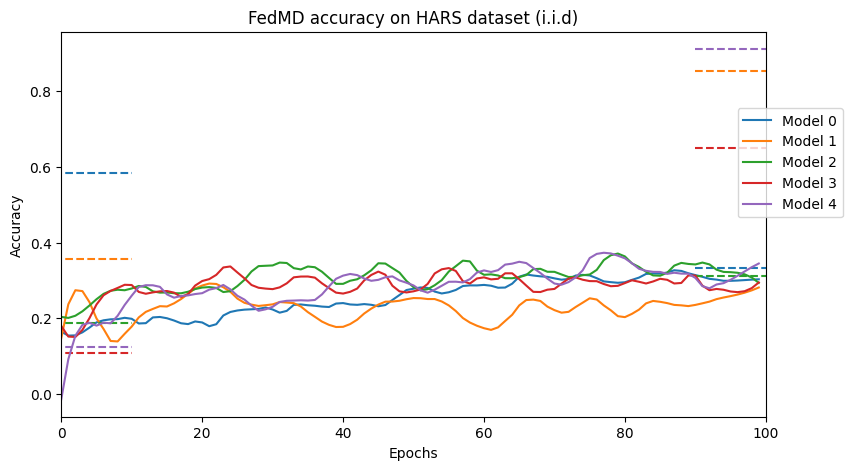

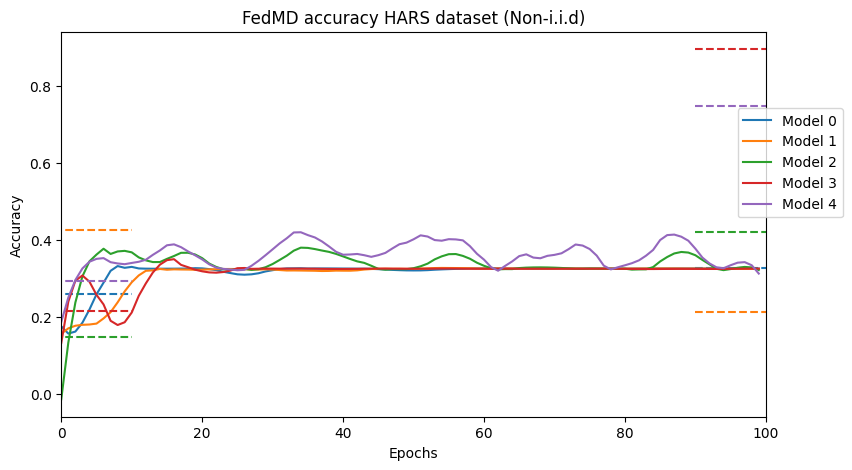

In [30]:

exp = Experiment('results/exp_smartHAR_FedMD')
last_local_accs_iid = exp.get_last_accuracies('local_train_iid')
last_local_accs_noniid = exp.get_last_accuracies('local_train_noniid')

last_central_accs_iid = exp.get_last_accuracies('central_train_iid')
last_central_accs_noniid = exp.get_last_accuracies('central_train_noniid')

fedAMD_iid = exp.get_accuracies('iid') 
fedAMD_noniid = exp.get_accuracies('noniid') 
smooth_iid = [smooth(acc) for acc in fedAMD_iid]
smooth_noniid = [smooth(acc) for acc in fedAMD_noniid]

# fedAMD_iid = exp.get_accuracies('fedMD_iid') 
# fedAMD_noniid = exp.get_accuracies('fedMD_noniid') 

# avg_left_iid, avg_right_iid = [np.mean(last_local_accs_iid)], [np.mean(last_central_accs_iid)]
# avg_left_noniid, avg_right_noniid = [np.mean(last_local_accs_noniid)], [np.mean(last_central_accs_noniid)]

smooth_center_iid = [smooth(np.mean(fedAMD_iid, axis = 0), window_len = 50, polyorder = 5)]
smooth_center_noniid = [smooth(np.mean(fedAMD_noniid, axis = 0), window_len = 70, polyorder = 5)]

center_iid = [np.mean(fedAMD_iid, axis = 0)]
center_noniid = [np.mean(fedAMD_noniid, axis = 0)]

fedAMD_noniid_limits = [np.min(fedAMD_noniid, axis = 0), np.max(fedAMD_noniid, axis = 0)]
fedAMD_iid_limits = [np.min(fedAMD_iid, axis = 0), np.max(fedAMD_iid, axis = 0)]


models_gains_iid = [int(round(fedAMD_iid[i].values[-1] - last_local_accs_iid[i], 2) *100) for i in range(len(last_local_accs_iid))]
models_gains_noniid = [int(round(fedAMD_noniid[i].values[-1] - last_local_accs_noniid[i], 2) *100) for i in range(len(last_local_accs_noniid))]
print('models gains iid:', models_gains_iid)
print('models gains noniid:', models_gains_noniid)

exp.plot_fedMD_like(last_local_accs_iid, smooth_iid, last_central_accs_iid, \
    labels = ['Model ' + str(i) for i in range(n_parties)],
     shades =None, 
     title = 'FedMD accuracy on HARS dataset (i.i.d)' , limit = 5)

exp.plot_fedMD_like(last_local_accs_noniid, smooth_noniid, last_central_accs_noniid, \
    labels = ['Model ' + str(i)  for i in range(n_parties)],
     shades =None, 
     title = 'FedMD accuracy HARS dataset (Non-i.i.d)', limit = 5)

models gains iid: [-6, 34, 59, 1, 67, 49, 44, 37, 49, 59]
models gains noniid: [17, 25, 24, 36, 36, 0, 36, -14, 7, 16]


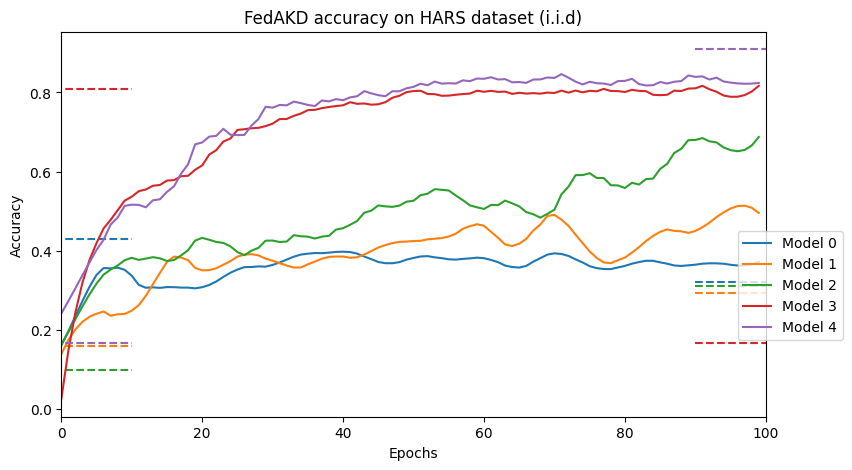

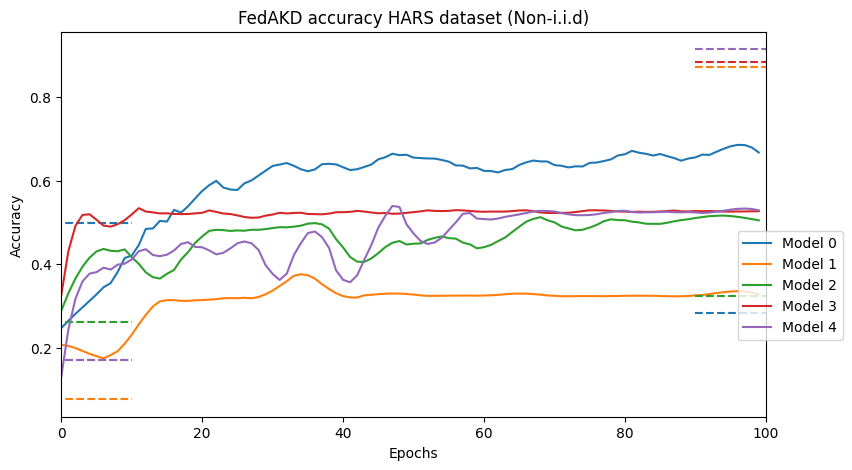

In [31]:

exp = Experiment('results/exp_smartHAR_FedWAKD')
last_local_accs_iid = exp.get_last_accuracies('local_train_iid')
last_local_accs_noniid = exp.get_last_accuracies('local_train_noniid')

last_central_accs_iid = exp.get_last_accuracies('central_train_iid')
last_central_accs_noniid = exp.get_last_accuracies('central_train_noniid')

fedAMD_iid = exp.get_accuracies('iid') 
fedAMD_noniid = exp.get_accuracies('noniid') 
smooth_iid = [smooth(acc) for acc in fedAMD_iid]
smooth_noniid = [smooth(acc) for acc in fedAMD_noniid]

# fedAMD_iid = exp.get_accuracies('fedMD_iid') 
# fedAMD_noniid = exp.get_accuracies('fedMD_noniid') 

# avg_left_iid, avg_right_iid = [np.mean(last_local_accs_iid)], [np.mean(last_central_accs_iid)]
# avg_left_noniid, avg_right_noniid = [np.mean(last_local_accs_noniid)], [np.mean(last_central_accs_noniid)]

smooth_center_iid = [smooth(np.mean(fedAMD_iid, axis = 0), window_len = 50, polyorder = 5)]
smooth_center_noniid = [smooth(np.mean(fedAMD_noniid, axis = 0), window_len = 70, polyorder = 5)]

center_iid = [np.mean(fedAMD_iid, axis = 0)]
center_noniid = [np.mean(fedAMD_noniid, axis = 0)]

fedAMD_noniid_limits = [np.min(fedAMD_noniid, axis = 0), np.max(fedAMD_noniid, axis = 0)]
fedAMD_iid_limits = [np.min(fedAMD_iid, axis = 0), np.max(fedAMD_iid, axis = 0)]


models_gains_iid = [int(round(fedAMD_iid[i].values[-1] - last_local_accs_iid[i], 2) *100) for i in range(len(last_local_accs_iid))]
models_gains_noniid = [int(round(fedAMD_noniid[i].values[-1] - last_local_accs_noniid[i], 2) *100) for i in range(len(last_local_accs_noniid))]
print('models gains iid:', models_gains_iid)
print('models gains noniid:', models_gains_noniid)

exp.plot_fedMD_like(last_local_accs_iid, smooth_iid, last_central_accs_iid, \
    labels = ['Model ' + str(i) for i in range(n_parties)],
     shades =None, 
     title = 'FedAKD accuracy on HARS dataset (i.i.d)' , limit = 5)

exp.plot_fedMD_like(last_local_accs_noniid, smooth_noniid, last_central_accs_noniid, \
    labels = ['Model ' + str(i)  for i in range(n_parties)],
     shades =None, 
     title = 'FedAKD accuracy HARS dataset (Non-i.i.d)', limit = 5)

In [35]:
exp_dirs = ['results/exp_smartHAR_FedMD', 'results/exp_smartHAR_FedWAKD']
exps = [Experiment(exp_dir) for exp_dir in exp_dirs]
exp_names = ['FedMD', 'FedAKD (ours)']
exp_colors = ['tab:orange', 'tab:green']

last_local_acc_iids = [exp.get_last_accuracies('local_train_iid') for exp in exps]
last_local_acc_noniids = [exp.get_last_accuracies('local_train_noniid') for exp in exps]
avg_local_acc_iids = [np.mean(last_local_acc_iids[i]) for i in range(len(exps))]
avg_local_acc_noniids = [np.mean(last_local_acc_noniids[i]) for i in range(len(exps))]


last_central_acc_iids = [exp.get_last_accuracies('central_train_iid') for exp in exps]
last_central_acc_noniids = [exp.get_last_accuracies('central_train_noniid') for exp in exps]
avg_central_acc_iids = [np.mean(last_central_acc_iids[i]) for i in range(len(exps))]
avg_central_acc_noniids = [np.mean(last_central_acc_noniids[i]) for i in range(len(exps))]


fed_iids, fed_noniids = [], []
for exp in exps :
    if 'fedMD_iid' in os.listdir(exp.root) :
        fed_iids.append(exp.get_accuracies('fedMD_iid'))
        fed_noniids.append(exp.get_accuracies('fedMD_noniid'))
    elif 'fedAMD_iid' in os.listdir(exp.root) : 
        fed_iids.append(exp.get_accuracies('fedAMD_iid'))
        fed_noniids.append(exp.get_accuracies('fedAMD_noniid'))
    else : 
        fed_iids.append(exp.get_accuracies('iid'))
        fed_noniids.append(exp.get_accuracies('noniid'))

fed_len = min([len(fed_iids[i][0]) for i in range(len(exps))])
fed_iids = [[fed_iids[i][j][:fed_len] for j in range(len(fed_iids[i]))] for i in range(len(exps))]
fed_noniids = [[fed_noniids[i][0][:fed_len] for j in range(len(fed_noniids[i]))] for i in range(len(exps))]


smooth_fed_iids = [smooth(np.mean(fed_iid, axis = 0)) for fed_iid in fed_iids]
smooth_fed_noniids = [smooth(np.mean(fed_noniid, axis = 0)) for fed_noniid in fed_noniids]
fed_iid_limits = [[np.min(fed_iid, axis = 0), np.max(fed_iid, axis = 0)] for fed_iid in fed_iids]
fed_noniid_limits = [[np.min(fed_noniid, axis = 0), np.max(fed_noniid, axis = 0)] for fed_noniid in fed_noniids]


avg_fed_iid = [np.mean(fed_iid, axis = 0) for fed_iid in fed_iids]
avg_fed_noniids = [np.mean(fed_noniid, axis = 0) for fed_noniid in fed_noniids]

fed_iid_gains = [[int(round(fed_iids[i][j].values[-1] - last_local_acc_iids[i][j], 2) *100) for j in range(len(last_local_acc_iids[i]))] for i in range(len(exps))]
fed_noniid_gains = [[int(round(fed_noniids[i][j].values[-1] - last_local_acc_noniids[i][j], 2) *100) for j in range(len(last_local_acc_noniids[i]))] for i in range(len(exps))]





In [33]:
fed_iid_gains[0]

[-28, -8, 12, 16, 21, -49, -9, -35, -1, -50]

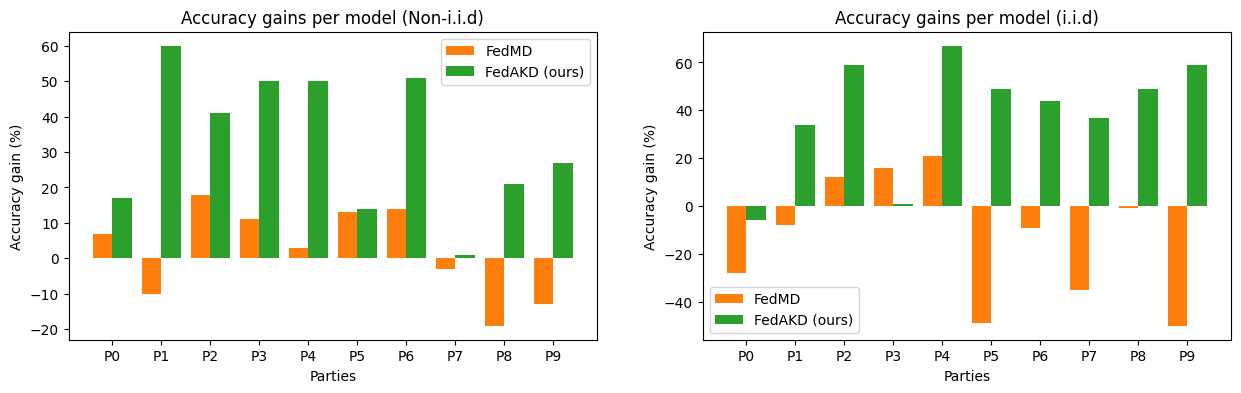

In [36]:
# plot accuracy gains per model

fig, ax = plt.subplots(1, 2, figsize = (15, 4))

ax[0].bar(np.arange(n_parties) - 0.2, fed_noniid_gains[0], label = exp_names[0], color = exp_colors[0], width = 0.4)
ax[0].bar(np.arange(n_parties) + 0.2, fed_noniid_gains[1], label = exp_names[1], color = exp_colors[1], width = 0.4) 
ax[0].set_title('Accuracy gains per model (Non-i.i.d)')
ax[0].set_xlabel('Parties')
ax[0].set_ylabel('Accuracy gain (%)')
ax[0].set_xticks(np.arange(n_parties))
ax[0].set_xticklabels(['P' + str(i) for i in range(n_parties)])
ax[0].legend()

ax[1].bar(np.arange(n_parties) - 0.2, fed_iid_gains[0], label = exp_names[0], color = exp_colors[0], width = 0.4)
ax[1].bar(np.arange(n_parties) + 0.2, fed_iid_gains[1], label = exp_names[1], color = exp_colors[1], width = 0.4)
ax[1].set_title('Accuracy gains per model (i.i.d)')
ax[1].set_xlabel('Parties')
ax[1].set_ylabel('Accuracy gain (%)')
ax[1].set_xticks(np.arange(n_parties))
ax[1].set_xticklabels(['P' + str(i) for i in range(n_parties)])
ax[1].legend()



In [ ]:
fed_noniid_gains, fed_iid_gains, np.mean(fed_noniid_gains, axis = 1), np.mean(fed_iid_gains, axis = 1)

([[4, 6, 6, 0, 1, -16, 21, 13, 14, 23],
  [25, 19, -7, 42, 41, 22, 43, 28, 56, 8]],
 [[-7, -11, 47, 55, 9, -5, -2, 52, 50, 54],
  [45, 0, 7, 61, 13, -16, -1, 18, 64, 63]],
 array([ 7.2, 27.7]),
 array([24.2, 25.4]))

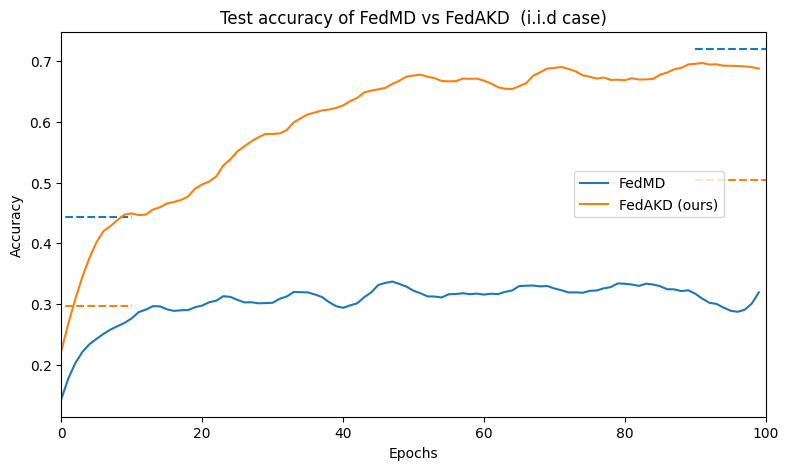

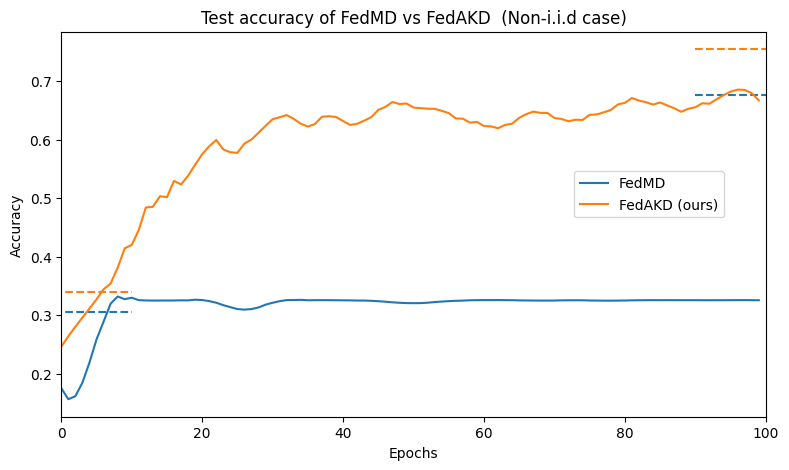

In [37]:
FL_methods =  ['FedMD', 'FedAKD (ours)']

smoothed_avg_fed_iid = [smooth(avg_fed_iid[i]) for i in range(len(avg_fed_iid))]
smoothed_avg_fed_noniid = [smooth(avg_fed_noniids[i]) for i in range(len(avg_fed_noniids))]

plot_fedMD_like_comparison(avg_local_acc_iids, smoothed_avg_fed_iid, avg_central_acc_iids, labels = FL_methods, shades = None, title = 'Test accuracy of FedMD vs FedAKD  (i.i.d case)')
plot_fedMD_like_comparison(avg_local_acc_noniids, smoothed_avg_fed_noniid, avg_central_acc_noniids, labels = FL_methods, shades =None, title = 'Test accuracy of FedMD vs FedAKD  (Non-i.i.d case)')


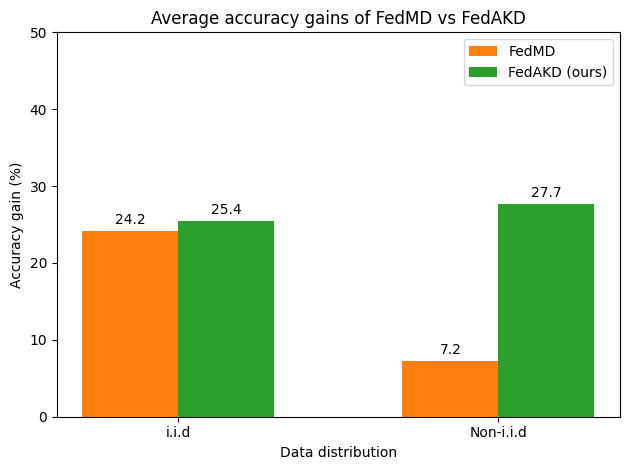

In [ ]:




x = np.arange(len(FL_methods))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
colors = list(mcolors.TABLEAU_COLORS.keys())
avg_iid_gains = [np.mean(fed_iid_gains[i]) for i in range(len(exps))]
avg_noniid_gains = [np.mean(fed_noniid_gains[i]) for i in range(len(exps))]
rects1 = ax.bar(x - width/2, [avg_iid_gains[0], avg_noniid_gains[0]], width, label='FedMD', color = exp_colors[0])
rects2 = ax.bar(x + width/2, [avg_iid_gains[1], avg_noniid_gains[1]], width, label='FedAKD (ours)', color = exp_colors[1])


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy gain (%)')
ax.set_title('Average accuracy gains of FedMD vs FedAKD')
ax.set_xticks(x)
ax.set_xticks(x, ['i.i.d', 'Non-i.i.d'])
ax.set_xlabel('Data distribution')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.set_ylim(0, 50)
fig.tight_layout()

plt.show()

In [ ]:
HARB_labels = ['study', 'walk', 'sleep']
HARS_labels = le.classes_ 

HARB_parties_classes = [
    [0, 1, 2], 
    [0, 1], 
    [2, 0],
    [0, 2],
    [1, 2],
    [0, 1, 2],
    [0, 1, 2],
    [0, 1, 2],
    [0], 
    [1, 0]
]
HARS_parties_classes = [
    [0, 1, 2, 3, 4], 
    [0, 1, 4, 5], 
    [2, 3, 4],
    [0, 2, 3],
    [1, 2, 3, 5],
    [0, 1, 3, 4, 2],
    [0, 1, 2],
    [0, 1, 2, 3, 5],
    [0, 3, 4, 5], 
    [1, 2, 5]
]

# plot scatter plot of classes distribution
def plot_classes_distribution(parties_classes, labels, title = None) :
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
    colors = list(mcolors.TABLEAU_COLORS.keys())
    # plot non-iid case
    for i in range(len(parties_classes[0])) :
        axs[0].scatter([i] * len(parties_classes[0][i]), parties_classes[0][i], color = colors[i], s = 100)
    axs[0].set_title('HARB local datasets distribution' + ' (Non-i.i.d case)', fontsize=22)
    axs[0].set_xlabel('Parties', fontsize=19)
    axs[0].set_ylabel('Classes', fontsize=19)
    axs[0].set_xticks(np.arange(len(parties_classes[0])), ['P' + str(i) for i in range(len(parties_classes[0]))])
    axs[0].set_yticks(np.arange(len(labels[0])), [l for l in labels[0]])
    axs[0].tick_params(axis='both', which='major', labelsize=15)

    
    # plot iid case
    n_classes = max(len(parties_classes[1][i]) for i in range(len(parties_classes[1])))
    for i in range(len(parties_classes[1])) :
        axs[1].scatter([i] * len(parties_classes[1][i]), parties_classes[1][i], color = colors[i], s = 100)
    axs[1].set_title('HARS local datasets distribution' + ' (Non-i.i.d case)', fontsize=22)
    axs[1].set_xlabel('Parties', fontsize=19)
    axs[1].set_ylabel('Classes', fontsize=19)
    axs[1].set_xticks(np.arange(len(parties_classes[1])), ['P' + str(i) for i in range(len(parties_classes[1]))])
    axs[1].set_yticks(np.arange(len(labels[1])), [l for l in labels[1]])
    axs[1].tick_params(axis='both', which='major', labelsize=15)
    plt.show()


plot_classes_distribution((HARB_parties_classes, HARS_parties_classes), (HARB_labels, HARS_labels), title = 'Class distribution')





NameError: name 'le' is not defined